<a href="https://colab.research.google.com/github/danielleitesoares/Work_Sentimental_Analyzer_Of_Restaurant_Issue/blob/main/Analise_dos_Sentimentos_Restaurantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Analise de Sentimentos Restaurantes**
> Equipe: Leonardo Rocha, Paulo Correa e Daniel Soares
> Turma 02





### 0.Seção de Importação das Livrarais 


In [58]:
# coding = utf-8  

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import pandas_profiling

### 1. Exibindo dados do Arquivo dataset-v2.dat

###### 1.1. Abrindo o Dataset 

In [44]:
nltk.download('punkt')
from textblob import TextBlob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
! git clone https://github.com/paulordie/sentimental_ds

Cloning into 'sentimental_ds'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 84 (delta 2), reused 6 (delta 2), pack-reused 77
Unpacking objects: 100% (84/84), done.
Checking out files: 100% (11/11), done.


In [46]:
%cd sentimental_ds/

/content/sentimental_ds/sentimental_ds/sentimental_ds/sentimental_ds


In [47]:
cols = ['title','reviewId', 'restaurantId','author','reviewBody','language','mobileDevice','userLocation','publicationDate','visitDate','ratingValue','itemReviewed','address','addressLocality','addressRegion','postalCode','country','website','email','phoneNumber','averageRating']
dados = pd.read_csv('pc-dataset-v2.dat', names= cols, engine = 'python', delimiter=',', skiprows=0, dtype = 'string')
dados.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed,address,addressLocality,addressRegion,postalCode,country,website,email,phoneNumber,averageRating
0,Jantar,692856288,2344932,larinhavercosa222,Comida maravilhosa. lugar do verdadeiro chicle...,pt,True,São Carlos. SP,26/07/2019,07/2019,5,Imperador dos Camar\u00F5es,Avenida Doutor Ant\u00F4nio Gouveia,<NA>,Alagoas,57030-170,Brasil,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5
1,Uma boa experi\u00EAncia.,229208487,3720906,Pano P,Comida boa. drinks legais e um ambiente bem ac...,pt,True,Manaus. AM,16/09/2014,None,4,Guacamole Natal,Avenida Praia de Ponta Negra 9068 Ponta Negra,<NA>,Rio Grande do Norte,59092-100,Brasil,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5
2,Otimo self service,679002332,2248105,Magma100,Excelente pra ir com a fam\u00EDlia! \u00D3tim...,pt,True,Goiânia. GO,04/06/2019,07/2018,4,Chica Pitanga,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,Aracaju. SE,15/03/2016,01/2016,5,Sorvetes Vi Sabor,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,<NA>,Brasil,None,None,None,4.0
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que j\u00E1 comi! Excelente...,pt,False,Rio de Janeiro. RJ,28/04/2015,04/2015,5,Z Deli Sandwich Shop,Rua Haddock Lobo 1386 Jardins,S\u00E3o Paulo,Estado de S\u00E3o Paulo,01414-002,Brasil,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5


In [48]:
dados.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            100000 non-null  string
 1   reviewId         100000 non-null  string
 2   restaurantId     100000 non-null  string
 3   author           100000 non-null  string
 4   reviewBody       100000 non-null  string
 5   language         99983 non-null   string
 6   mobileDevice     100000 non-null  string
 7   userLocation     100000 non-null  string
 8   publicationDate  100000 non-null  string
 9   visitDate        100000 non-null  string
 10  ratingValue      100000 non-null  string
 11  itemReviewed     100000 non-null  string
 12  address          99938 non-null   string
 13  addressLocality  86319 non-null   string
 14  addressRegion    100000 non-null  string
 15  postalCode       95036 non-null   string
 16  country          100000 non-null  string
 17  website    

In [49]:
dados.tail()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed,address,addressLocality,addressRegion,postalCode,country,website,email,phoneNumber,averageRating
99995,Nova op\u00E7\u00E3o no Paseo!!!,672210394,17424548,Fabiano B,Ainda n\u00E3o inaugurado oficialmente. est\u0...,pt,True,Porto Alegre. RS,07/05/2019,05/2019,5,Boteco Maestro,Avenida Wenceslau Escobar 1823,Porto Alegre,Rio Grande do Sul,91900-000,Brasil,http://www.facebook.com/botecomaestro,None,+55 51 99353-6602,4.0
99996,Bom,380904400,2440184,Chris L,Bom atendimento. lugar bonito. comida muito go...,pt,True,Cork. Irlanda,08/06/2016,01/2016,4,Casa do Marqu\u00EAs,Rua Marques do Pombal. 1814 Higien\u00F3polis,Porto Alegre,Rio Grande do Sul,90540-000,Brasil,http://galeteriacasadomarques.com.br/,galeteriacasadomarques@galeteriacasadomarques....,+55 51 3343-4303,4.5
99997,Bom bar,186111858,2392996,Guilherme P,O Rio Scenarium \u00E9 uma das baladas mais fa...,pt,False,São Paulo. SP,27/11/2013,11/2013,4,Rio Scenarium,Rua do Lavradio 20 Centro,Rio de Janeiro,Estado do Rio de Janeiro,20230-070,Brasil,http://www.rioscenarium.art.br,None,+55 21-3147-9000,4.5
99998,Me senti enganada...,152745909,1062290,LisianeCohem,Fui por indica\u00E7\u00E3o e com boa expectat...,pt,True,Porto Alegre. RS,21/02/2013,None,2,Celeiro,Rua Dias Ferreira 199,Rio de Janeiro,Estado do Rio de Janeiro,22431-050,Brasil,http://www.celeiroculinaria.com.br,celeiro@celeiroculinaria.com.br,55 21 2274 7843,3.5
99999,Restaurante excelente,649755498,12433911,brunotulio,Experi\u00EAncia fant\u00E1stica com comida de...,pt,True,Manaus. AM,02/02/2019,02/2019,5,Coco Bambu Manaus,Avenida Coronel Teixeira. 5705 Ponta Negra. Sh...,Manaus,Rio Amazonas,69037-000,Brasil,http://www.facebook.com/cocobambumanausoficial/,rh.manaus@cocobambu.com,+55 92 3667-7430,5.0


In [50]:
diaDaVisita = dados.iloc[:,9:10]
diaDaVisita

,visitDate
0,07/2019
1,None
2,07/2018
3,01/2016
4,04/2015
...,...
99995,05/2019
99996,01/2016
99997,11/2013
99998,None


In [51]:
dados.count()

title              100000
reviewId           100000
restaurantId       100000
author             100000
reviewBody         100000
language            99983
mobileDevice       100000
userLocation       100000
publicationDate    100000
visitDate          100000
ratingValue        100000
itemReviewed       100000
address             99938
addressLocality     86319
addressRegion      100000
postalCode          95036
country            100000
website            100000
email              100000
phoneNumber        100000
averageRating      100000
dtype: int64

In [52]:
dados.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool

In [53]:
avaliacaoGeral = dados.iloc[:,10:11]
avaliacaoGeral.describe()

,ratingValue
count,100000
unique,5
top,5
freq,51169


In [54]:
dispositivoMovel = dados.iloc[:,6:7]
dispositivoMovel

,mobileDevice
0,True
1,True
2,True
3,False
4,False
...,...
99995,True
99996,True
99997,False
99998,True


In [55]:
def translateByTextBlob():
  dic2 = pd.DataFrame(dados)
  dic2['reviewBody']
  count = 0
  for _x in dic2['reviewBody']:
      count = count + 1  
      print(type(_x))
      x = _x.encode('utf-16', 'surrogatepass').decode('utf-16')
      print(x)
      
      print(count) #vai imprimir todos os reviews= 
          
      comentario_blob = TextBlob(x)
      print(type(comentario_blob))
      comentario_blob_us = comentario_blob.translate(to='us')

      for sentence_br, sentence in zip(comentario_blob.sentences, comentario_blob_us.sentences):
          print(sentence_br, ':', sentence.sentiment.subjectivity)
      if count == 5:
          print('**End**')
          break  

####1.2. Informações sobre o DataFrame

In [63]:
pandas_profiling.ProfileReport(dados) # foi instalado o biblioteca com o comando  !pip install -U pandas-profiling

OSError: ignored

In [56]:
localDoUsuario = dados.iloc[:,7:8]
localDoUsuario

,userLocation
0,São Carlos. SP
1,Manaus. AM
2,Goiânia. GO
3,Aracaju. SE
4,Rio de Janeiro. RJ
...,...
99995,Porto Alegre. RS
99996,Cork. Irlanda
99997,São Paulo. SP
99998,Porto Alegre. RS


In [57]:
dados.describe()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed,address,addressLocality,addressRegion,postalCode,country,website,email,phoneNumber,averageRating
count,100000,100000,100000,100000,100000,99983,100000,100000,100000,100000,100000,100000,99938,86319,100000,95036,100000,100000,100000,100000,100000
unique,59592,100000,14982,67203,99997,9,2,4114,3106,118,5,13579,14724,23,27,8029,1,7169,3110,9868,9
top,Muito bom,434679532,1098021,None,Boa op\u00E7\u00E3o de restaurante em Aracaju....,pt,False,São Paulo. SP,30/07/2013,None,5,Coco Bambu Frutos do Mar,Av. Beira Mar. 3698 Bairro Mucuripe,S\u00E3o Paulo,Estado de S\u00E3o Paulo,59090-000,Brasil,None,None,None,4.5
freq,1803,1,1083,813,2,99013,57599,14707,200,4330,51169,1083,1083,17455,17455,1418,100000,14473,51782,7655,48989


### 2. Análise dos Dados do Dataframe

In [ ]:
df.loc[df.Name.str.contains('Mr', flags=re.I, regex=True)].head()

### 3. *Gráfico* dos Dados do DataFrame

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


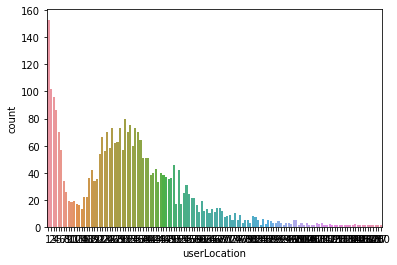

In [16]:
sns.countplot(dados.groupby('publicationDate').userLocation.count());

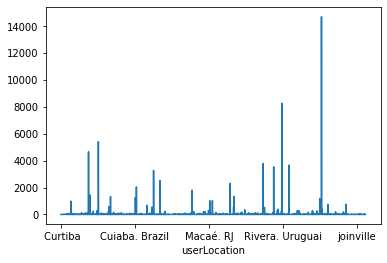

In [17]:
dados.groupby('userLocation').averageRating.count().plot()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


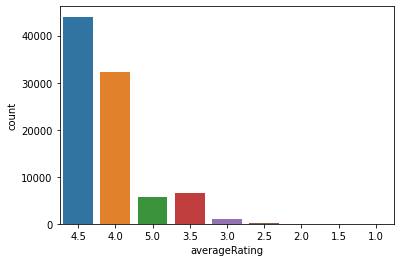

In [ ]:
sns.countplot(dados.averageRating);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


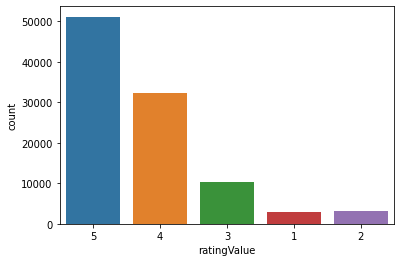

In [18]:
sns.countplot(dados.ratingValue);

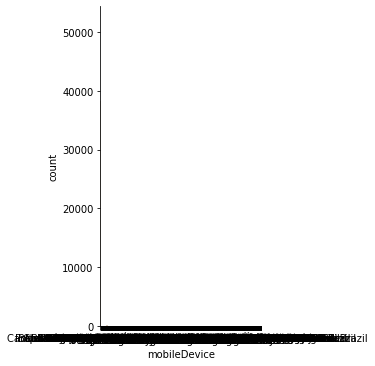

In [ ]:
sns.catplot(x="mobileDevice", kind="count", palette="ch:.25", data=dados)

### 4. Analise dos Sentimentos 

In [ ]:
translateByTextBlob()

NameError: ignored